## Домашняя работа по теме: "Задача оттока: варианты постановки, возможные способы решения"

Выполнила Моисеенкова Полина

Задание:
1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Посмотрим на данные

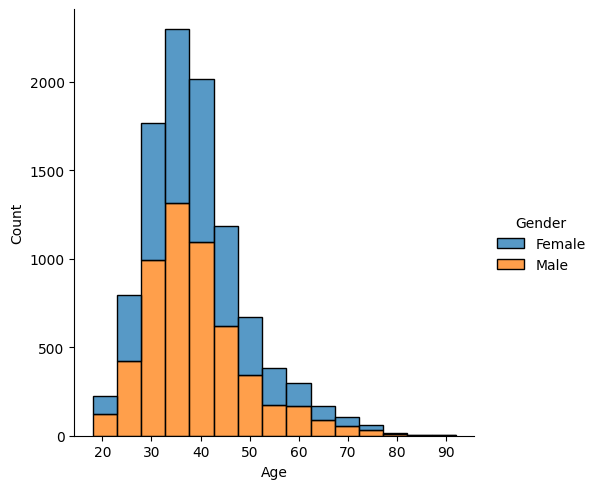

In [4]:
sns.displot(df, x='Age', hue='Gender', bins=15, multiple="stack")

Выбросов по возрастам и по полу нет. Данные по возрасту можно стандартизировать, а по полу применить OHE кодирование.

In [5]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Всего 3 страны, можно применить OHE кодирование

<AxesSubplot: xlabel='Balance', ylabel='Count'>

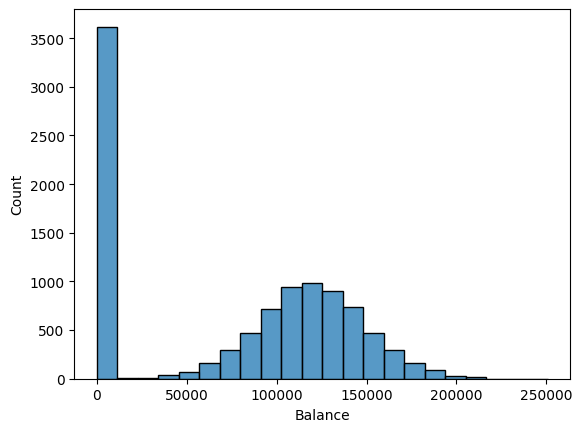

In [6]:
sns.histplot(df, x='Balance')

In [7]:
df['Balance'].mode()

0    0.0
Name: Balance, dtype: float64

Имеется много клиентов с нулевым балансом, нужна стандартизация данных поля Balance.

In [8]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

Для поля 'NumOfProducts' можно тоже применить OHE кодирование, так как всего 4 значения

<AxesSubplot: xlabel='CreditScore', ylabel='Count'>

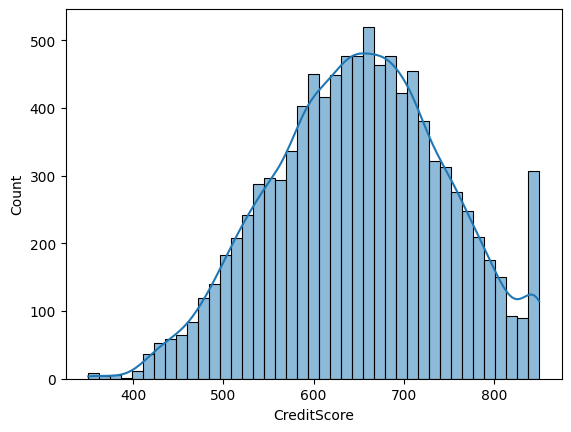

In [9]:
sns.histplot(df, x="CreditScore", kde=True)

CreitScore можно стандартизировать

<AxesSubplot: xlabel='Tenure', ylabel='Count'>

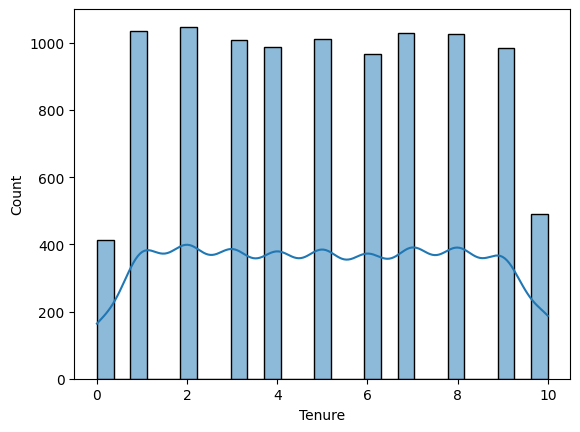

In [10]:
sns.histplot(df, x="Tenure", kde=True)

'Tenure' можно применить OHE кодирование

In [11]:
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [12]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

к полям 'HasCrCard' и 'IsActiveMember' также можно применить OHE кодирование

<AxesSubplot: xlabel='EstimatedSalary', ylabel='Count'>

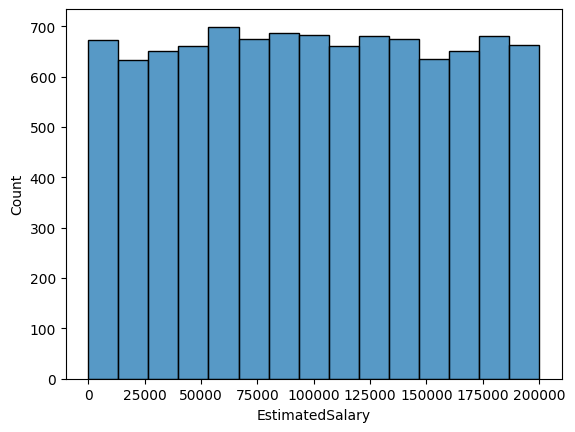

In [13]:
sns.histplot(df, x='EstimatedSalary', bins=15)

'EstimatedSalary' можно стандартизировать

In [31]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Таким образом, зададим списки признаков

In [14]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [15]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [16]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [17]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [18]:
# объединим в единынй пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [19]:
def get_classification_report(y_test, y_score, b=1):

    """
    Функция для оценки качества модели

    """
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(
        y_test, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    print(f'ROC_AUC score is: {roc_auc_score(y_test, y_score)}')
    return {'fscore': fscore[ix], 'precision': precision[ix],
            'recall': recall[ix], 'roc_auc_score': roc_auc_score(y_test, y_score)}

In [20]:
def ML_algorithm(ML_function):
    classifier = Pipeline([
        ('features',feats),
        ('classifier', ML_function),
    ])


    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    y_test_pred = classifier.predict(X_test)
    results = {'y_score': y_score, 'y_test_pred': y_test_pred, 'classifier': classifier}
    return results

## Бустинговая модель LightGBM

In [21]:
lightGBM = ML_algorithm(ML_function=lgbm.LGBMClassifier(random_state=42))

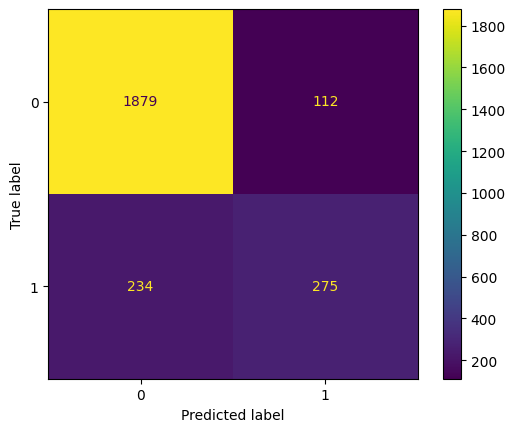

In [22]:
ConfusionMatrixDisplay.from_estimator(lightGBM['classifier'], X_test, y_test)

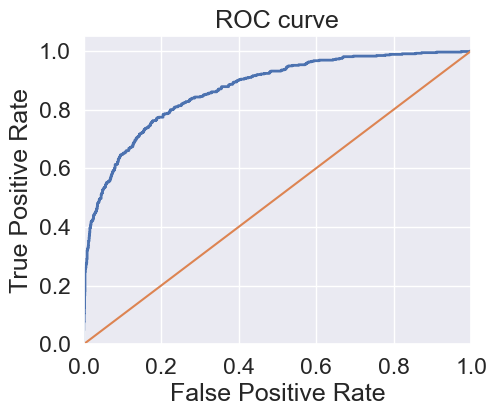

Best Threshold=0.361180, F-Score=0.639, Precision=0.633, Recall=0.646
ROC_AUC score is: 0.8704913762224706


In [23]:
lightGBM_report = get_classification_report(y_test=np.array(y_test),
                        y_score=lightGBM['y_score'])

## Бустинговая модель CatBoost

In [27]:
CatBoost = ML_algorithm(ML_function=catb.CatBoostClassifier(silent=True, random_state=21))

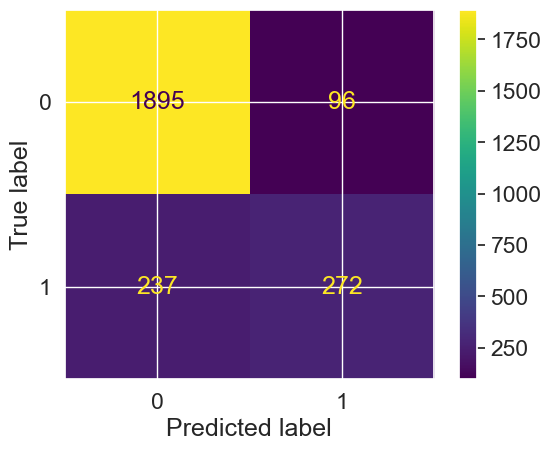

In [28]:
ConfusionMatrixDisplay.from_estimator(CatBoost['classifier'], X_test, y_test)

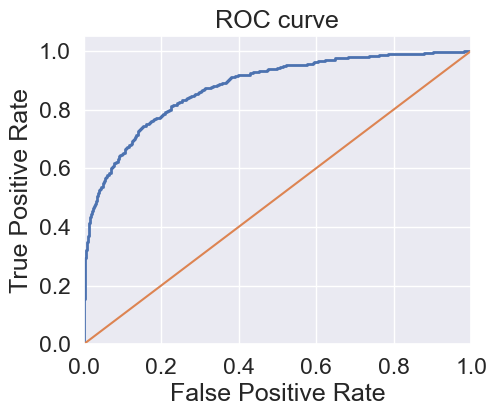

Best Threshold=0.407699, F-Score=0.640, Precision=0.665, Recall=0.617
ROC_AUC score is: 0.8774208890893105


In [36]:
CatBoost_report = get_classification_report(y_test=np.array(y_test),
                        y_score=CatBoost['y_score'])

## Модель с логистической регрессией

In [24]:
logreg = ML_algorithm(LogisticRegression(random_state=42))

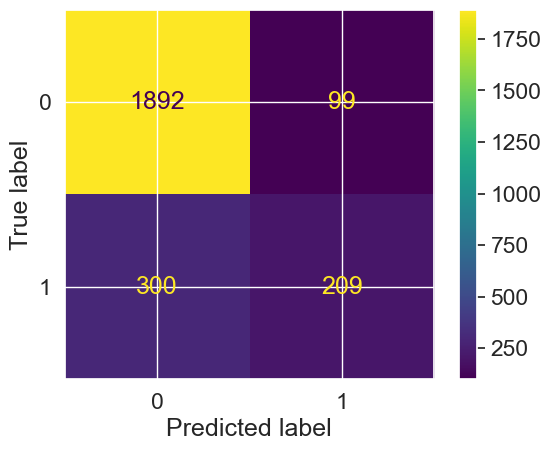

In [25]:
ConfusionMatrixDisplay.from_estimator(logreg['classifier'], X_test, y_test)

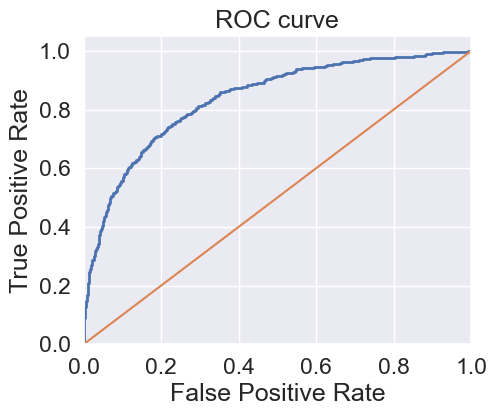

Best Threshold=0.310532, F-Score=0.586, Precision=0.529, Recall=0.656
ROC_AUC score is: 0.8376614213864157


In [26]:
logreg_report = get_classification_report(y_test=np.array(y_test),
                        y_score=logreg['y_score'])

### Выбор лучшей модели

In [30]:
all_reports = [logreg_report, lightGBM_report, CatBoost_report]
table = {'precision': [report['precision'].round(3) for report in all_reports],
        'recall': [report['recall'].round(3) for report in all_reports],
        'roc_auc_score': [report['roc_auc_score'].round(3) for report in all_reports],
        'f_score': [report['fscore'].round(3) for report in all_reports]}
table = pd.DataFrame(data=table, index=['Logistic Regression', 'LightGBM', 'CatBoost'])
table

,precision,recall,roc_auc_score,f_score
Logistic Regression,0.529,0.656,0.838,0.586
LightGBM,0.633,0.646,0.870,0.639
CatBoost,0.665,0.617,0.877,0.640


Лучшие показатели у модели CatBoost. Для оценки выбрала F-меру, так как классы не сбалансированы. 

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

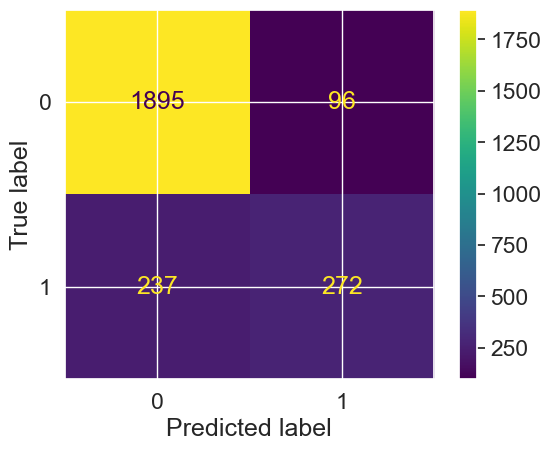

In [32]:
# Посмотрим еще раз на полученную матрицу и проведем оценку

ConfusionMatrixDisplay.from_estimator(CatBoost['classifier'], X_test, y_test)

In [46]:
cm = confusion_matrix(y_test, CatBoost['y_test_pred'])
cm
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [48]:
retain_sum = (FP + TP) * 1
income = TP * 2

print(f'Выручка: {income}, Траты: {retain_sum}')

Выручка: 3790, Траты: 1991
